In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import randint
from tqdm import tqdm
import gym
import random


In [2]:
df_org = pd.read_csv('Apple History.csv')
df = df_org.iloc[::-1].reset_index(drop=True)
print(df.head())

df_train = df[0:2417]
df_test = df[2317:2517]
print(df_train.shape)
print(df_test.shape)

def get_observable_space(df):
    df_dict = {}
    chunk_size = 100  
    
    for start in range(len(df) - chunk_size + 1):
        chunk = df.iloc[start:start + chunk_size]
        df_dict[start] = chunk
    return df_dict

df_train_dict = get_observable_space(df_train)

         Date  Close    Volume  Open  High   Low
0  03/28/2014   3.88  13183890  3.93  3.97  3.87
1  03/31/2014   4.01  15380930  3.93  4.02  3.90
2  04-01-2014   4.07  18711230  4.04  4.10  4.02
3  04-02-2014   4.06  14834590  4.12  4.12  4.06
4  04-03-2014   4.00  16780420  4.07  4.10  3.97
(2417, 6)
(200, 6)


In [3]:
# class TradingActionSpace():
#     def __init__(self,):
#         self.full_action_space = [0,1,2]
#         self.current_action_space = [0,1,2]

#     def get_all_actions(self):
#         return self.full_action_space

#     def get_action(self,):
#         self.current_action_space = random.choice(self.current_action_space)


class TradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, window_size, wallet_balance):
        super(TradingEnv, self).__init__()
        self.df = df.copy()
        self.df['actions'] = np.nan
        print(self.df.shape)
        self.window_size = window_size
        self.action_space = gym.spaces.Discrete(3) #1:hold,2:buy,3:sell
        INF = np.inf
        self.observation_space = gym.spaces.Box(low=-INF, high=INF, shape=(self.window_size, len(df.columns)), dtype=np.float32)
        self.current_step = 0
        self.terminated = None
        self.truncated = None
        self.figure, self.ax = None, None
        self.wallet_balance = wallet_balance
        self.quantity = 0

    def reset(self):
        #clear actions column
        self.terminated = False
        self.truncated = False
        self.current_step = 0
        observation = self._get_observation()
        info = {}
        return observation, info
    
    def step(self, action):
        self.current_step += 1
        observation = self._get_observation()
        self._update_action(action)
        reward = self._get_reward()
        info = {}
        self._render()
        return observation, reward, self.terminated, self.truncated, info
    
    def _render(self, ):
        self.figure, self.ax = plt.subplots(figsize=(10, 5))
        observation = self._get_observation()
        observation.iloc[:,0:1].plot(ax=self.ax)
        for i in range(len(observation)):
            if observation['actions'].iloc[i] == 1:  
                self.ax.scatter(observation.index[i], observation.iloc[i, 0], color='green', zorder=5)
            elif observation['actions'].iloc[i] == 2:  
                self.ax.scatter(observation.index[i], observation.iloc[i, 0], color='red', zorder=5)
    
        self.ax.set_ylabel('Value')
        self.ax.set_xlabel('Time')
        self.ax.set_title(f"Wlt Bal - {self.wallet_balance}, Qty - {self.quantity}")
        plt.draw()
        plt.pause(1)
        clear_output(wait=True)

    def _update_action(self, action):
        if self.current_step + self.window_size - 1 < len(self.df):
            self.df.at[self.current_step + self.window_size - 1, 'actions'] = action
            self._update_wallet(action)
            self._update_quantity(action)
        else:
            print("Attempted to update action beyond the DataFrame's length.")

    def _update_wallet(self, action):
        if (action == 1 and self.quantity > 0) or (action == 2 and self.quantity < 0):
            self.wallet_balance -= self._get_observation().iloc[-1,0]
        elif (action == 2 and self.quantity > 0) or (action == 1 and self.quantity < 0):
            self.wallet_balance += self._get_observation().iloc[-1,0]
        elif (action == 2 or action == 1) and self.quantity == 0:
            self.wallet_balance -= self._get_observation().iloc[-1,0]

    def _update_quantity(self, action):
        if action == 1:
            self.quantity += 1
        elif action ==2:
            self.quantity -= 1

    def _get_observation(self, ):
        return self.df[self.current_step: self.current_step+self.window_size]
    
    def _get_reward(self,):
        return 1
    
def prepTradingEnv(df):
    env = TradingEnv(df, window_size=50, wallet_balance = 120)
    nS = env.observation_space  
    nA = env.action_space.n
    phi = lambda x: x
    envName = 'TradingEnv'
    return nS, nA, env, phi, envName

nS, nA, env, phi, envName = prepTradingEnv(df_train.iloc[:, 1:])


(2417, 6)


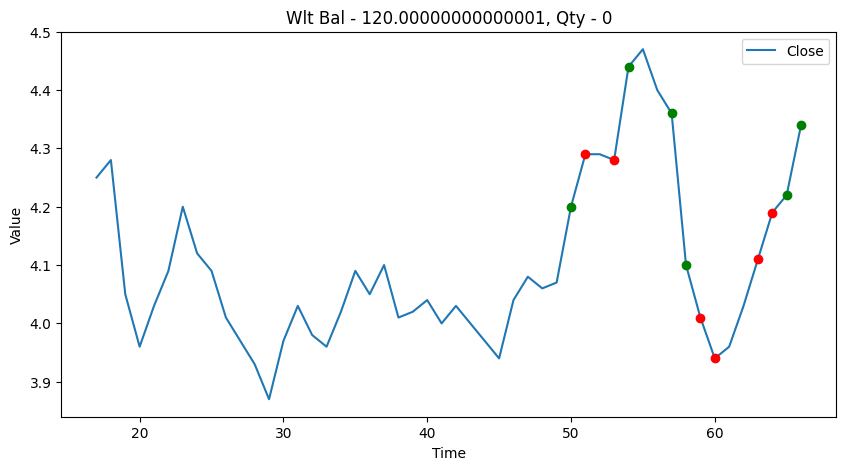

In [4]:
observation = env.reset()

action_list = [1,2,0,2,1,0,0,1,1,2,2,0,0,2,2,1,1]


for i in range(0, len(action_list)):
    action = action_list[i]
    observation, reward, terminated, truncated, info = env.step(action)


In [5]:
action_dict = {
    'action_all': gym.spaces.Discrete(3),
    'action_buy_hold': gym.spaces.Discrete(2),
    'action_sell_hold': gym.spaces.Discrete(2)
}

In [28]:
action_space = gym.spaces.Dict(action_dict)
action_space.sample()

OrderedDict([('action_all', 0),
             ('action_buy_hold', 1),
             ('action_sell_hold', 1)])